# LQR法でヒューマノイドのレギュレーションのチュートリアル

In [3]:
import mujoco
mujoco.MjModel.from_xml_string('<mujoco/>')
import numpy as np
from typing import Callable, Optional, Union, List
import scipy.linalg

# Graphics and plotting.
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

In [6]:
with open('mujoco/model/humanoid/humanoid.xml', 'r') as f:
  xml = f.read()

In [59]:
# print(xml)

In [7]:
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

""

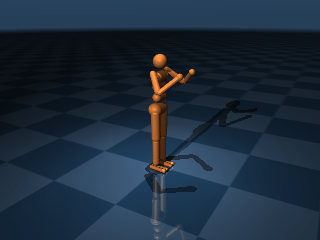

In [8]:
mujoco.mj_forward(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())

""

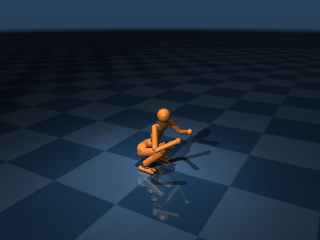

""

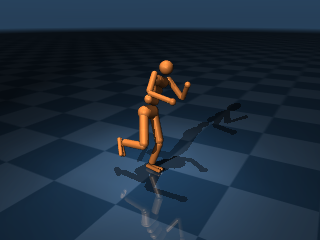

""

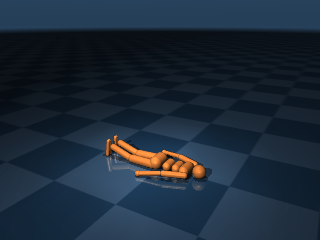

""

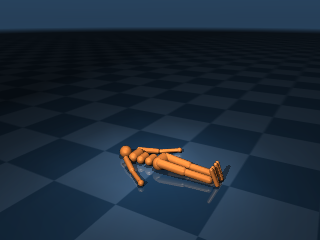

In [12]:
## keyframeに保存された姿勢を表示
for key in range(model.nkey):
  mujoco.mj_resetDataKeyframe(model, data, key)
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)
  media.show_image(renderer.render())

In [13]:
#中腰から自由落下
DURATION  = 3   # seconds
FRAMERATE = 60  # Hz

# Initialize to the standing-on-one-leg pose.
mujoco.mj_resetDataKeyframe(model, data, 1)

frames = []
while data.time < DURATION:
  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data)
    pixels = renderer.render()
    frames.append(pixels)

# Display video.
media.show_video(frames, fps=FRAMERATE)

In [15]:
DURATION  = 3   # seconds
FRAMERATE = 60  # Hz

# Make a new camera, move it to a closer distance.
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 2

mujoco.mj_resetDataKeyframe(model, data, 1)

frames = []
while data.time < DURATION:
  # Set control vector.
  data.ctrl = np.random.randn(model.nu)#乱数で全軸に適当な速度指令を与える

  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    # Set the lookat point to the humanoid's center of mass.
    camera.lookat = data.body('torso').subtree_com #特定のbodyをカメラに追尾させる

    renderer.update_scene(data, camera)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)

## 順動力学と逆動力学計算
- 力与えて加速度算出する
    - `mj_forward`
- 加速度与えて力算出
    - `mj_inverse`

In [72]:
mujoco.mj_resetDataKeyframe(model, data, 1) #中腰姿勢に初期化
mujoco.mj_forward(model, data) 
data.qacc = 0  # Assert that there is no the acceleration.
mujoco.mj_inverse(model, data)
print(data.qfrc_inverse) #加速度を発生させない全軸の力

[  0.      0.    275.879 -33.186   4.995  -6.688  -4.305   3.693 -15.451 -10.906   0.412  -1.613
  -9.793  -2.312  -0.366  -5.913  -0.417  -1.914   5.759   2.665  -0.202  -5.755   0.994   1.141
  -1.987   3.821   1.151]


In [73]:
joint_names = [model.joint(i).name for i in range(model.njnt)]
all_dof = 0
joint_types = ["free", "ball", "slide", "hinge"]
for jn in joint_names:
    n_pos = len(data.joint(jn).qacc)
    j_type = model.joint(jn).type[0]
    print(jn,":",n_pos, "-DoF, type:", joint_types[j_type])
    all_dof += n_pos
print("all-DoF is", all_dof)

root : 6 -DoF, type: free
abdomen_z : 1 -DoF, type: hinge
abdomen_y : 1 -DoF, type: hinge
abdomen_x : 1 -DoF, type: hinge
hip_x_right : 1 -DoF, type: hinge
hip_z_right : 1 -DoF, type: hinge
hip_y_right : 1 -DoF, type: hinge
knee_right : 1 -DoF, type: hinge
ankle_y_right : 1 -DoF, type: hinge
ankle_x_right : 1 -DoF, type: hinge
hip_x_left : 1 -DoF, type: hinge
hip_z_left : 1 -DoF, type: hinge
hip_y_left : 1 -DoF, type: hinge
knee_left : 1 -DoF, type: hinge
ankle_y_left : 1 -DoF, type: hinge
ankle_x_left : 1 -DoF, type: hinge
shoulder1_right : 1 -DoF, type: hinge
shoulder2_right : 1 -DoF, type: hinge
elbow_right : 1 -DoF, type: hinge
shoulder1_left : 1 -DoF, type: hinge
shoulder2_left : 1 -DoF, type: hinge
elbow_left : 1 -DoF, type: hinge
all-DoF is 27


- フローティングベースの先から回転関節が連なっている

In [74]:
print(data.qfrc_inverse[2])

275.87856563199045


この値がでかいということは、倒れない（動かない）ためにフローティングベースにZ軸方向にでかい力が必要ということ

Zの位置を、床にちょっとめり込んだとこから、1マイクロメートルずつずらしていったらこの値は？↓

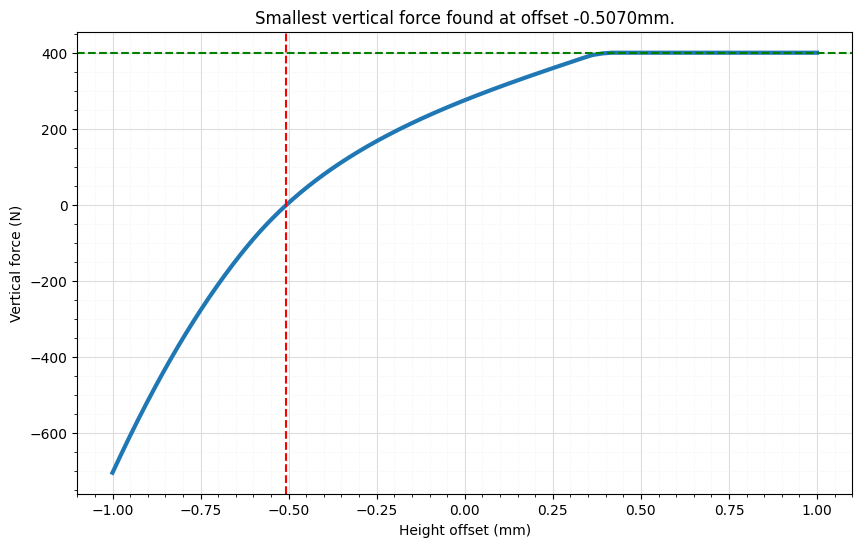

In [18]:
height_offsets = np.linspace(-0.001, 0.001, 2001)
vertical_forces = []
for offset in height_offsets:
  mujoco.mj_resetDataKeyframe(model, data, 1)
  mujoco.mj_forward(model, data)
  data.qacc = 0
  # Offset the height by `offset`.
  data.qpos[2] += offset
  mujoco.mj_inverse(model, data)
  vertical_forces.append(data.qfrc_inverse[2])

# Find the height-offset at which the vertical force is smallest.
idx = np.argmin(np.abs(vertical_forces))
best_offset = height_offsets[idx]

# Plot the relationship.
plt.figure(figsize=(10, 6))
plt.plot(height_offsets * 1000, vertical_forces, linewidth=3)
# Red vertical line at offset corresponding to smallest vertical force.
plt.axvline(x=best_offset*1000, color='red', linestyle='--')
# Green horizontal line at the humanoid's weight.
weight = model.body_subtreemass[1]*np.linalg.norm(model.opt.gravity)
plt.axhline(y=weight, color='green', linestyle='--')
plt.xlabel('Height offset (mm)')
plt.ylabel('Vertical force (N)')
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.minorticks_on()
plt.title(f'Smallest vertical force '
          f'found at offset {best_offset*1000:.4f}mm.')
plt.show()

- 床に深めにめり込んでいるときは、反発して帰ってくるのを抑えるZにマイナス方向の力が必要
- 逆に床から浮き出すと、ロボにかかる重力と等しい400Nに収束する
- この力が0に近くなる-0.5付近ではつまり、余計な力なしで、止まっていれる（床が支えてくれる）
    - **0じゃないんだ！**

In [48]:
mujoco.mj_resetDataKeyframe(model, data, 1)
mujoco.mj_forward(model, data)
data.qacc = 0
data.qpos[2] += best_offset
qpos0 = data.qpos.copy()  # Save the position setpoint.
mujoco.mj_inverse(model, data)
qfrc0 = data.qfrc_inverse.copy()
print('desired forces:', qfrc0)

desired forces: [  0.      0.     -0.191  -3.447   0.222  -0.817   2.586  14.637 -18.64  -10.906   0.412  -1.613
  -9.793  -2.312  -0.366 -23.755  -2.171  12.264  26.101  13.337  -0.113  -5.755   0.994   1.141
  -1.987   3.821   1.151]


In [68]:
print(data.actuator_moment.shape)
np.atleast_2d(qfrc0).shape
# np.linalg.pinv(data.actuator_moment).shape

(21, 27)


(1, 27)

In [69]:
# data.actuator_momentはモーメントモーメントアーム行列＝ヤコビアンだと思うが、
# 右からかけてるとことかよくわからん
ctrl0 = np.atleast_2d(qfrc0) @ np.linalg.pinv(data.actuator_moment)
ctrl0 = ctrl0.flatten()  # Save the ctrl setpoint.
print('control setpoint:', ctrl0)

control setpoint: [ 0.065  0.366 -0.466 -0.273  0.01  -0.013 -0.122 -0.116 -0.018 -0.594 -0.054  0.102  0.326  0.667
 -0.006 -0.288  0.05   0.029 -0.099  0.191  0.029]


In [70]:
#多分、仮想仕事の原理的に静力学を使って、姿勢を保つ入力を求めている
data.ctrl = ctrl0
mujoco.mj_forward(model, data)
print('actuator forces:', data.qfrc_actuator)

actuator forces: [  0.      0.      0.      0.      0.      0.      2.586  14.637 -18.64  -10.906   0.412  -1.613
  -9.793  -2.312  -0.366 -23.755  -2.171  12.264  26.101  13.337  -0.113  -5.755   0.994   1.141
  -1.987   3.821   1.151]


In [71]:
DURATION  = 3   # seconds
FRAMERATE = 60  # Hz

# Set the state and controls to their setpoints.
mujoco.mj_resetData(model, data)
data.qpos = qpos0
data.ctrl = ctrl0

frames = []
while data.time < DURATION:
  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    # Set the lookat point to the humanoid's center of mass.
    camera.lookat = data.body('torso').subtree_com
    renderer.update_scene(data, camera)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)